#### OBJETIVO: Modelos Predictivos de PM2.5 simples

In [ ]:
#Librerias
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

print("librerias ok")

librerias ok


In [11]:
# Funcion para evaluar los modelos siguientes
def evaluar_modelo(modelo, 
                   X_test, 
                   y_test=None, 
                   df_test=None,
                   variable_real="PM25",
                   tipo_modelo="LM"):
    """
    Evalúa el desempeño de un modelo predictivo.
    
    Parameters
    ----------
    modelo : modelo entrenado (sklearn o xgboost)
    X_test : DataFrame o array con variables predictoras
    y_test : array con valores reales (solo para XGB)
    df_test : DataFrame con variable_real (para LM, RF, etc.)
    variable_real : str, nombre de la variable objetivo
    tipo_modelo : str, 'LM', 'RF', 'XGB', etc.
    """

    # Predicciones
    y_pred = modelo.predict(X_test)

    # Valores reales
    if tipo_modelo == "XGB":
        y_true = np.array(y_test)
    else:
        y_true = np.array(df_test[variable_real])

    # Armar DataFrame
    df = pd.DataFrame({
        "predicciones": y_pred,
        "valores_reales": y_true
    })

    # Filtrar predicciones negativas
    df = df[df["predicciones"] > 0]

    # Metricas
    r2 = np.corrcoef(df["predicciones"], df["valores_reales"])[0, 1] ** 2
    pearson = pearsonr(df["valores_reales"], df["predicciones"])[0]
    rmse = np.sqrt(mean_squared_error(df["valores_reales"], df["predicciones"]))
    bias = np.mean(df["predicciones"] - df["valores_reales"])

    resultados = pd.DataFrame({
        "R2": [round(r2, 5)],
        "Pearson": [round(pearson, 3)],
        "RMSE": [round(rmse, 3)],
        "Bias": [round(bias, 3)],
        "Min_Pred": [round(df["predicciones"].min(), 3)],
        "Max_Pred": [round(df["predicciones"].max(), 3)]
    })

    return resultados




def evaluar_modelo_rlm(modelo, X_test, y_test):
    pred = modelo.predict(X_test)

    df = pd.DataFrame({
        "pred": pred,
        "real": y_test
    })

    df = df[df["pred"] > 0]

    r2 = r2_score(df["real"], df["pred"])
    pearson = df["real"].corr(df["pred"])
    rmse = np.sqrt(mean_squared_error(df["real"], df["pred"]))
    bias = (df["pred"] - df["real"]).mean()

    resultados = pd.DataFrame({
        "R2": [round(r2, 5)],
        "Pearson": [round(pearson, 3)],
        "RMSE": [round(rmse, 3)],
        "Bias": [round(bias, 3)],
        "Min_Pred": [round(df["pred"].min(), 3)],
        "Max_Pred": [round(df["pred"].max(), 3)]
    })

    return resultados, df


MX
        R2  Pearson   RMSE   Bias  Min_Pred  Max_Pred
0  0.16922    0.411  9.068  0.033     15.58    47.867


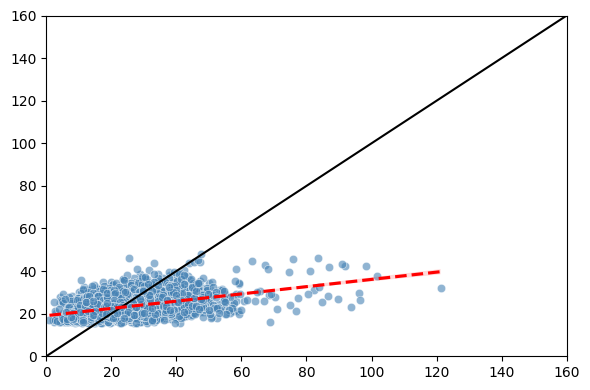

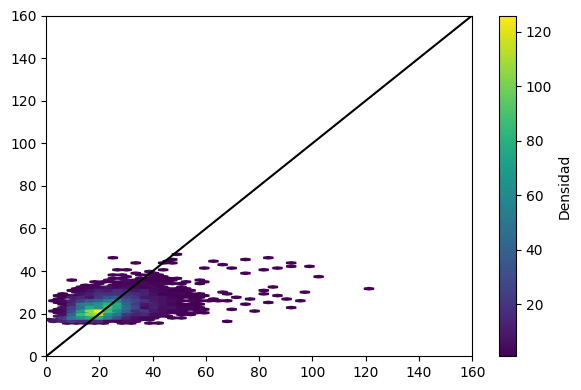

In [ ]:
### -------------- REGRESION LINEAL SIMPLE --------------------------
# Dataset de entrada de entrenamiento y testeo

estacion = "MX"
modelo_id = "1"

dir_base = f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/modelos/ParticionDataSet/Modelo_{modelo_id}/"

train_data = pd.read_csv(f"{dir_base}/M{modelo_id}_train_{estacion}.csv")
test_data  = pd.read_csv(f"{dir_base}/M{modelo_id}_test_{estacion}.csv")

#Setear las variables del modelo
X_train = train_data[["AOD_055"]]
y_train = train_data["PM25"]
X_test = test_data[["AOD_055"]]

# Generar modelo predictivo: Regresion lineal simple
modelo_lm = LinearRegression()
modelo_lm.fit(X_train, y_train)

resultados_lm = evaluar_modelo(modelo=modelo_lm,
    X_test=X_test,
    df_test=test_data,
    variable_real="PM25",
    tipo_modelo="LM"
)
print(estacion)
print(resultados_lm)
#######################################
#Hacer plot con las predicciones realizadas a partir del modelo entrenamo con el dataset de entrenamiento
test_data["pred"] = modelo_lm.predict(X_test)

plt.figure(figsize=(6,4))

sns.scatterplot(
    x=test_data["PM25"],
    y=test_data["pred"],
    color="steelblue",
    alpha=0.6
)

# Linea 1:1
plt.plot([0,160], [0,160], color="black")

# Regresion
sns.regplot(
    x=test_data["PM25"],
    y=test_data["pred"],
    scatter=False,
    color="red",
    line_kws={"linestyle": "--"}
)

plt.xlim(0,160)
plt.ylim(0,160)
plt.xlabel("")
plt.ylabel("")
plt.title("")
plt.tight_layout()
plt.show()
#####################################################
### Otro plot, de densidad

plt.figure(figsize=(6,4))

plt.hexbin(
    test_data["PM25"],
    test_data["pred"],
    gridsize=35,
    cmap="viridis",
    mincnt=1
)

plt.plot([0,160], [0,160], color="black")
plt.xlim(0,160)
plt.ylim(0,160)
plt.colorbar(label="Densidad")
plt.tight_layout()
plt.show()


      R2  Pearson   RMSE   Bias  Min_Pred  Max_Pred
0  0.106    0.326  9.412  0.073    17.445    44.119


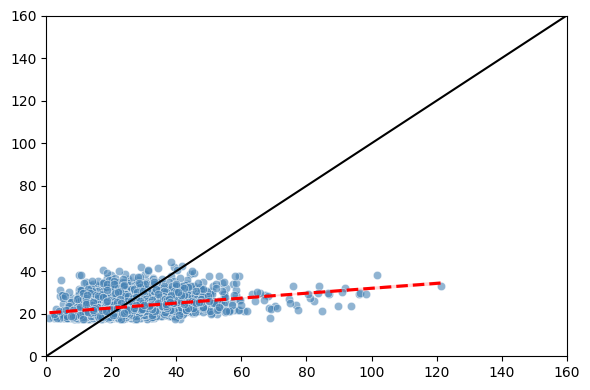

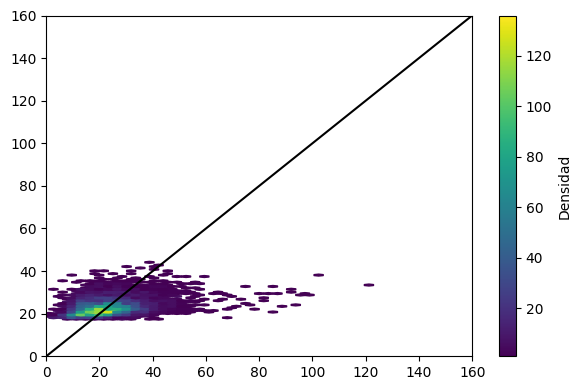

In [ ]:
### -------------- REGRESION LINEAL SIMPLE CON CORRECCIONES POR BLH --------------------------
# Dataset de entrada de entrenamiento y testeo

estacion = "MX"
modelo_id = "1"

dir_base = f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/modelos/ParticionDataSet/Modelo_{modelo_id}/"

train_data = pd.read_csv(f"{dir_base}/M{modelo_id}_train_{estacion}.csv")
test_data  = pd.read_csv(f"{dir_base}/M{modelo_id}_test_{estacion}.csv")

# Generacion de variables ==> correccion del AOD por blh
train_data["AOD_055_correct"] = train_data["AOD_055"] / train_data["blh_mean"]
test_data["AOD_055_correct"]  = test_data["AOD_055"]  / test_data["blh_mean"]


#Setear las variables para el modelo
X_train = train_data[["AOD_055_correct"]]
y_train = train_data["PM25"]

X_test = test_data[["AOD_055_correct"]]
#Generar mnodelo
modelo_lm_corr = LinearRegression()
modelo_lm_corr.fit(X_train, y_train)

resultados_lm_corr = evaluar_modelo(
    modelo=modelo_lm_corr,
    X_test=X_test,
    df_test=test_data,
    variable_real="PM25",
    tipo_modelo="LM"
)

print(resultados_lm_corr)

#############################################
# Plot:
test_data["pred"] = modelo_lm_corr.predict(X_test)

plt.figure(figsize=(6,4))

sns.scatterplot(
    x=test_data["PM25"],
    y=test_data["pred"],
    color="steelblue",
    alpha=0.6
)

# Línea 1:1
plt.plot([0,160], [0,160], color="black")

# Línea de regresión
sns.regplot(
    x=test_data["PM25"],
    y=test_data["pred"],
    scatter=False,
    color="red",
    line_kws={"linestyle": "--"}
)

plt.xlim(0,160)
plt.ylim(0,160)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

###############
#Otro plot similar
plt.figure(figsize=(6,4))

plt.hexbin(
    test_data["PM25"],
    test_data["pred"],
    gridsize=35,
    cmap="viridis",
    mincnt=1
)

plt.plot([0,160], [0,160], color="black")
plt.xlim(0,160)
plt.ylim(0,160)
plt.colorbar(label="Densidad")
plt.tight_layout()
plt.show()


CH
        R2  Pearson    RMSE   Bias  Min_Pred  Max_Pred
0  0.04575    0.214  15.643  0.111    18.832   110.409


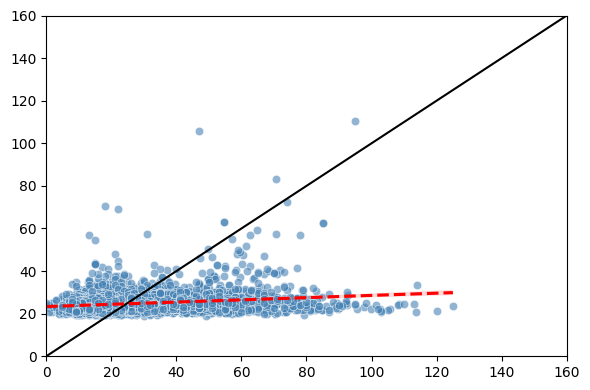

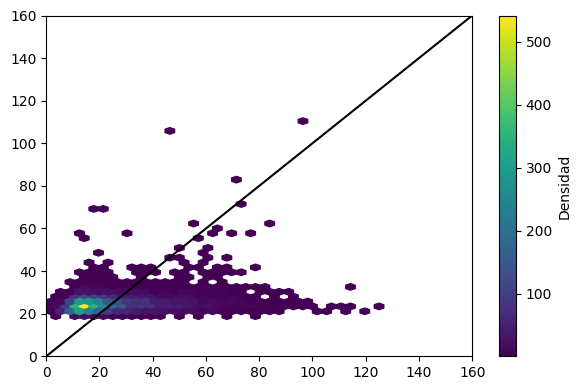

In [7]:
### -------------- REGRESION LINEAL SIMPLE CON CORRECCIONES POR HUMEDAD --------------------------
# Dataset de entrada de entrenamiento y testeo

estacion = "CH"
modelo_id = "RH"

dir_base = f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/modelos/ParticionDataSet/Modelo_{modelo_id}/"

train_data = pd.read_csv(f"{dir_base}/M{modelo_id}_train_{estacion}.csv")
test_data  = pd.read_csv(f"{dir_base}/M{modelo_id}_test_{estacion}.csv")

# Correccion por humedad
train_data["funcRH"] = 1 / (1 - (train_data["RH"] / 100))
test_data["funcRH"]  = 1 / (1 - (test_data["RH"]  / 100))

train_data["AOD_055_correct"] = train_data["AOD_055"] / train_data["funcRH"]
test_data["AOD_055_correct"]  = test_data["AOD_055"]  / test_data["funcRH"]

#Setear variables importantes
X_train = train_data[["AOD_055_correct"]]
y_train = train_data["PM25"]

X_test = test_data[["AOD_055_correct"]]

#Ajustar el modelo
modelo_lm_rh = LinearRegression()
modelo_lm_rh.fit(X_train, y_train)

#Evaluar el modelo
resultados_lm_rh = evaluar_modelo(
    modelo=modelo_lm_rh,
    X_test=X_test,
    df_test=test_data,
    variable_real="PM25",
    tipo_modelo="LM"
)

print(estacion)
print(resultados_lm_rh)

#########################################################
#Plot
test_data["pred"] = modelo_lm_rh.predict(X_test)


plt.figure(figsize=(6,4))

sns.scatterplot(
    x=test_data["PM25"],
    y=test_data["pred"],
    color="steelblue",
    alpha=0.6
)

# Línea 1:1
plt.plot([0,160], [0,160], color="black")

# Línea de regresión
sns.regplot(
    x=test_data["PM25"],
    y=test_data["pred"],
    scatter=False,
    color="red",
    line_kws={"linestyle": "--"}
)

plt.xlim(0,160)
plt.ylim(0,160)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

########################################
#Otro plot
plt.figure(figsize=(6,4))

plt.hexbin(
    test_data["PM25"],
    test_data["pred"],
    gridsize=35,
    cmap="viridis",
    mincnt=1
)

plt.plot([0,160], [0,160], color="black")
plt.xlim(0,160)
plt.ylim(0,160)
plt.colorbar(label="Densidad")
plt.tight_layout()
plt.show()



CH
        R2  Pearson    RMSE   Bias  Min_Pred  Max_Pred
0  0.31598    0.562  13.239  0.068    17.563   158.183


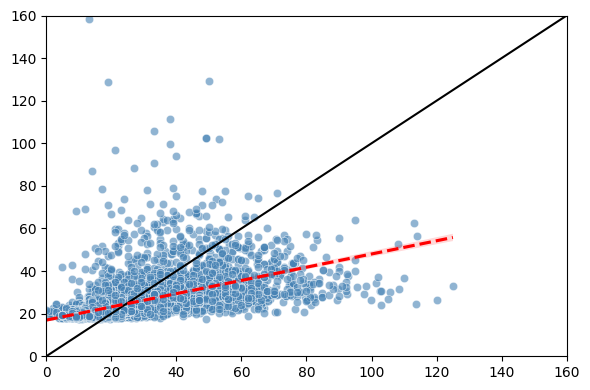

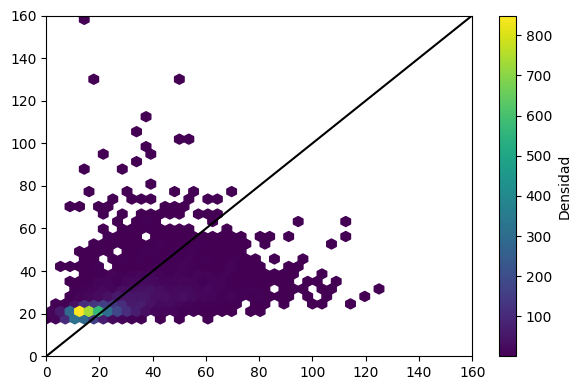

In [9]:
### -------------- REGRESION LINEAL SIMPLE CON CORRECCIONES POR AMBAS CORRECCIONES AL AOD --------------------------
# Dataset de entrada de entrenamiento y testeo


estacion = "CH"
modelo_id = "RH"   # mismo identificador que en R

dir_base = f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/modelos/ParticionDataSet/Modelo_{modelo_id}/"

train_data = pd.read_csv(f"{dir_base}/M{modelo_id}_train_{estacion}.csv")
test_data  = pd.read_csv(f"{dir_base}/M{modelo_id}_test_{estacion}.csv")

# Generar variables con ambas correcciones al AOD
train_data["AOD_corrected"] = (
    train_data["AOD_055"] * (1 - train_data["RH"] / 100)
) / train_data["blh_mean"]

test_data["AOD_corrected"] = (
    test_data["AOD_055"] * (1 - test_data["RH"] / 100)
) / test_data["blh_mean"]

# Se setean las variables de importancia
X_train = train_data[["AOD_corrected"]]
y_train = train_data["PM25"]

X_test = test_data[["AOD_corrected"]]

# Ajsutar el modelo
modelo_lm_blhrh = LinearRegression()
modelo_lm_blhrh.fit(X_train, y_train)

#Evaluar el modelo
resultados_lm_blhrh = evaluar_modelo(
    modelo=modelo_lm_blhrh,
    X_test=X_test,
    df_test=test_data,
    variable_real="PM25",
    tipo_modelo="LM"
)
#Resultados
print(estacion)
print(resultados_lm_blhrh)
###########################################################
#Plot

test_data["pred"] = modelo_lm_blhrh.predict(X_test)

plt.figure(figsize=(6,4))

sns.scatterplot(
    x=test_data["PM25"],
    y=test_data["pred"],
    color="steelblue",
    alpha=0.6
)

# Línea 1:1
plt.plot([0,160], [0,160], color="black")

# Línea de regresión
sns.regplot(
    x=test_data["PM25"],
    y=test_data["pred"],
    scatter=False,
    color="red",
    line_kws={"linestyle": "--"}
)

plt.xlim(0,160)
plt.ylim(0,160)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

#3## otro plot
plt.figure(figsize=(6,4))

plt.hexbin(
    test_data["PM25"],
    test_data["pred"],
    gridsize=35,
    cmap="viridis",
    mincnt=1
)

plt.plot([0,160], [0,160], color="black")
plt.xlim(0,160)
plt.ylim(0,160)
plt.colorbar(label="Densidad")
plt.tight_layout()
plt.show()








CH
        R2  Pearson    RMSE   Bias  Min_Pred  Max_Pred
0  0.56687    0.753  10.841  0.106     0.022    95.293


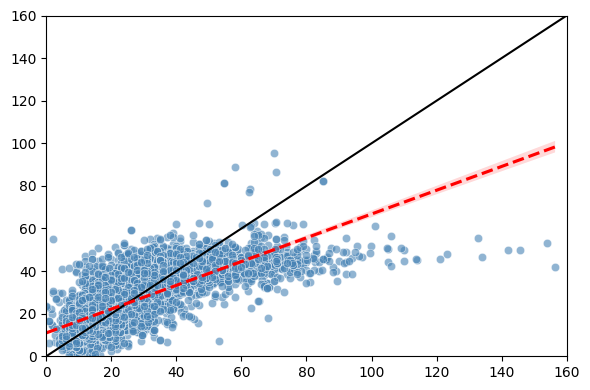

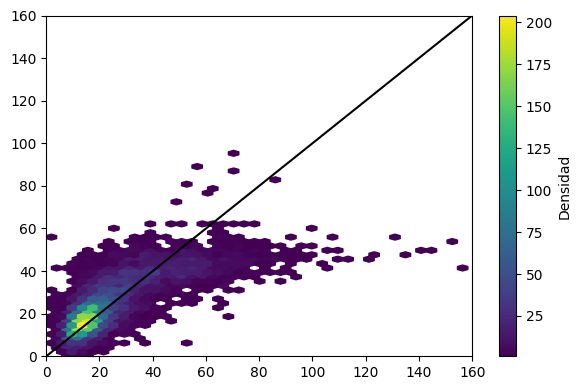

In [14]:
### -------------- REGRESION LINEAL MULTIPLE --------------------------
# Dataset de entrada de entrenamiento y testeo

estacion = "CH"
modelo_id = "1"

dir_base = f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/modelos/ParticionDataSet/Modelo_{modelo_id}/"

train_data = pd.read_csv(f"{dir_base}/M{modelo_id}_train_{estacion}.csv")
test_data  = pd.read_csv(f"{dir_base}/M{modelo_id}_test_{estacion}.csv")

#Revisar para cada sitio las variables finales
features = [
    "AOD_055",
    "ndvi",
    "BCSMASS_dia",
    "DUSMASS_dia",
    "SO2SMASS_dia",
    "SO4SMASS_dia",
    "SSSMASS_dia",
    "blh_mean",
    "t2m_mean",
    "DEM",
    "d2m_mean",
    "v10_mean",
    "u10_mean",
    "tp_mean",
    "dayWeek"
]

#Setear variables para ajustar el modelo
X_train = train_data[features]
y_train = train_data["PM25"]

X_test = test_data[features]
y_test = test_data["PM25"]

#Ajustar modelo
modelo_rlm = LinearRegression()
modelo_rlm.fit(X_train, y_train)

#Evaluar el desempeño con funcion
resultados_rlm, df_plot = evaluar_modelo_rlm(modelo_rlm, X_test, y_test)

print(estacion)
print(resultados_rlm)

############################################################
#Plot
plt.figure(figsize=(6,4))

sns.scatterplot(
    x=df_plot["real"],
    y=df_plot["pred"],
    color="steelblue",
    alpha=0.6
)

# Linea 1:1
plt.plot([0,160], [0,160], color="black")

# Linea de regresión
sns.regplot(
    x=df_plot["real"],
    y=df_plot["pred"],
    scatter=False,
    color="red",
    line_kws={"linestyle": "--"}
)

plt.xlim(0,160)
plt.ylim(0,160)
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()
plt.show()

#########################
#Otro plot
plt.figure(figsize=(6,4))

plt.hexbin(
    df_plot["real"],
    df_plot["pred"],
    gridsize=40,
    cmap="viridis",
    mincnt=1
)

plt.plot([0,160], [0,160], color="black")
plt.xlim(0,160)
plt.ylim(0,160)
plt.colorbar(label="Densidad")
plt.tight_layout()
plt.show()


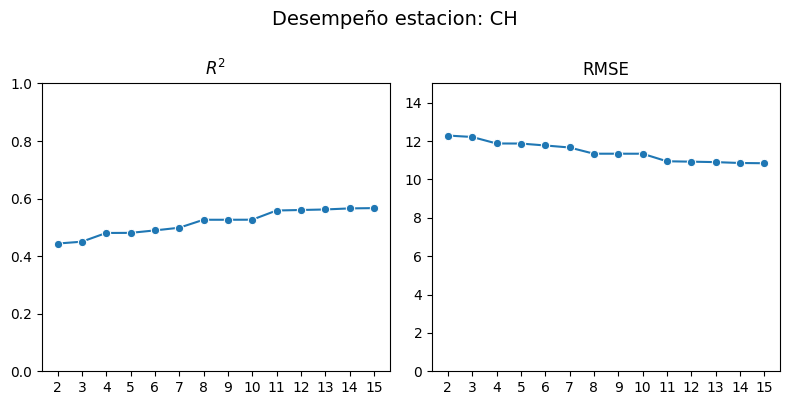

In [30]:
### -------------- REGRESION LINEAL MULTIPLE --------------------------
# Pero se agregan progresivamente las variables
# Dataset de entrada de entrenamiento y testeo

estacion = "CH"
modelo_id = "1"

dir_base = f"D:/Josefina/Proyectos/ProyectoChile/{estacion}/modelos/ParticionDataSet/Modelo_{modelo_id}/"

train_data = pd.read_csv(f"{dir_base}/M{modelo_id}_train_{estacion}.csv")
test_data  = pd.read_csv(f"{dir_base}/M{modelo_id}_test_{estacion}.csv")

#Variables hay que considerar las particularidaes de cada centro urbano
variables = [
    "blh_mean", "d2m_mean", "t2m_mean", "v10_mean", "u10_mean", "tp_mean",
    "ndvi", "BCSMASS_dia", "DUSMASS_dia", "SO2SMASS_dia", "SO4SMASS_dia",
    "SSSMASS_dia", "DEM", "dayWeek"
]


# Generamos otra funcion particular para esto
def evaluar_modelo_lm(modelo, X_test, y_test):
    pred = modelo.predict(X_test)

    df = pd.DataFrame({
        "pred": pred,
        "real": y_test
    })

    df = df[df["pred"] > 0]

    r2 = r2_score(df["real"], df["pred"])
    pearson = df["real"].corr(df["pred"])
    rmse = np.sqrt(mean_squared_error(df["real"], df["pred"]))
    bias = (df["pred"] - df["real"]).mean()

    return {
        "R2": round(r2, 5),
        "Pearson": round(pearson, 3),
        "RMSE": round(rmse, 3),
        "Bias": round(bias, 3),
        "Min_Pred": round(df["pred"].min(), 3),
        "Max_Pred": round(df["pred"].max(), 3)
    }


# Iteramos entre las variables para evaluar el desempeño
resultados_modelos = []

for i, var in enumerate(variables, start=1):
    vars_actuales = ["AOD_055"] + variables[:i]

    X_train = train_data[vars_actuales]
    X_test  = test_data[vars_actuales]

    modelo_lm = LinearRegression()
    modelo_lm.fit(X_train, y_train)

    res = evaluar_modelo_lm(modelo_lm, X_test, y_test)
    res["Modelo"] = f"Modelo_{i+1}"
    res["Variables"] = ", ".join(vars_actuales)

    resultados_modelos.append(res)

tabla_resultados = pd.DataFrame(resultados_modelos)
tabla_resultados["Num_Variables"] = tabla_resultados["Variables"].apply(
    lambda x: len(x.split(", "))
)
#Resultados en formato df
tabla_resultados = pd.DataFrame(resultados_modelos)
tabla_resultados["Num_Variables"] = tabla_resultados["Variables"].apply(
    lambda x: len(x.split(", "))
)

#Unimos todo columas/filas
data_melt = tabla_resultados.melt(
    id_vars="Num_Variables",
    value_vars=["R2", "RMSE"],
    var_name="Metrica",
    value_name="Valor"
)

#############################################################################
#Plot con ambas metricas

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True)
fig.suptitle(
    f"Desempeño estacion: {estacion}",
    fontsize=14,
    y=1.0
)
# R2
sns.lineplot(
    data=data_melt[data_melt["Metrica"] == "R2"],
    x="Num_Variables",
    y="Valor",
    marker="o",
    ax=axes[0]
)
axes[0].set_ylim(0, 1)
axes[0].set_title(r"$R^2$")
axes[0].set_xlabel("")
axes[0].set_ylabel("")

# RMSE
sns.lineplot(
    data=data_melt[data_melt["Metrica"] == "RMSE"],
    x="Num_Variables",
    y="Valor",
    marker="o",
    ax=axes[1]
)
axes[1].set_ylim(0, 15)
axes[1].set_title("RMSE")
axes[1].set_xlabel("")
axes[1].set_ylabel("")

# 👉 Forzar ticks de 1 en 1
x_ticks = range(
    int(tabla_resultados["Num_Variables"].min()),
    int(tabla_resultados["Num_Variables"].max()) + 1
)

for ax in axes:
    ax.set_xticks(x_ticks)

plt.tight_layout()
plt.show()

